In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


res, info = tfds.load(
    'oxford_flowers102',
    split='test+train+validation',
    shuffle_files = True,
    as_supervised=True,
    with_info=True
)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete11DIBD/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete11DIBD/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete11DIBD/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [2]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

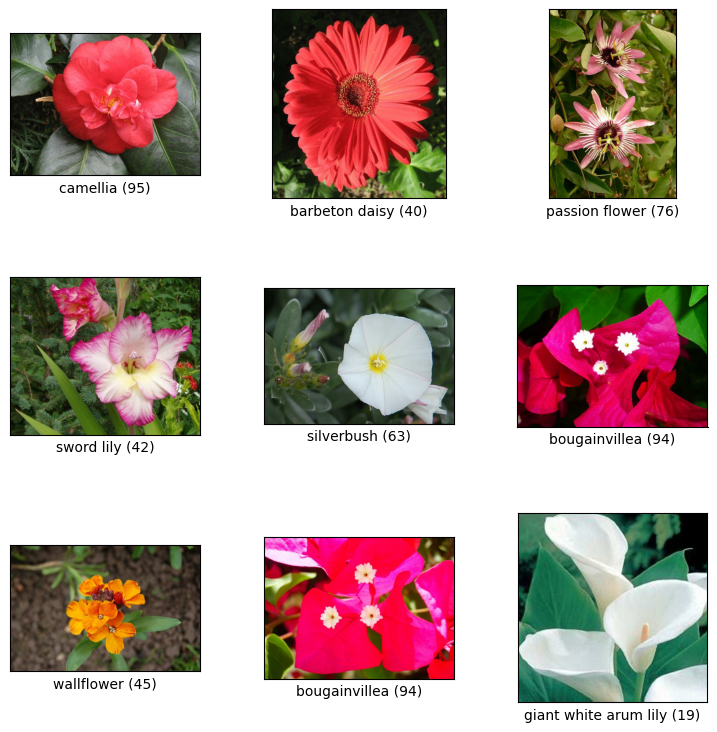

In [3]:
fig = tfds.show_examples(res, info)

In [4]:
img_size = (150, 150)

In [5]:
def create_dataset(ds, batch_size=32):
    
    ds = ds.map(
            lambda x, y: (tf.image.resize(x, img_size), y), 
            num_parallel_calls=tf.data.AUTOTUNE
        )
    ds = ds.shuffle(ds.cardinality(), seed=123, reshuffle_each_iteration=True)
    
    ds = ds.batch(batch_size) 
    return ds.prefetch(1)

In [6]:
train_size = int(len(res) * 0.5)
val_size = int(len(res) * 0.25)
test_size = len(res) - train_size - val_size
train_ds = res.take(train_size)
val_ds = res.skip(train_size).take(val_size)
test_ds = res.skip(train_size).skip(val_size)
assert(len(test_ds) == test_size)
train_ds = create_dataset(train_ds)
val_ds = create_dataset(val_ds)
test_ds = create_dataset(test_ds)

In [7]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [8]:
base_model = tf.keras.applications.VGG19(
        input_shape=(150, 150, 3),
        include_top=False,
        weights="imagenet",
)
base_model.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [28]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    data_augmentation,
    layers.Rescaling(scale=1.0/255),
    base_model,
    # new layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(102, activation='softmax'),
])

In [10]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['acc']
             )

epochs = 25
history1 = model.fit(train_ds, epochs=epochs,
                   validation_data=val_ds)

Epoch 1/25
128/128 [==============================] - 36s 155ms/step - loss: 4.4066 - acc: 0.0581 - val_loss: 3.4002 - val_acc: 0.2462
Epoch 2/25
128/128 [==============================] - 23s 132ms/step - loss: 3.3284 - acc: 0.2079 - val_loss: 2.4468 - val_acc: 0.4231
Epoch 3/25
128/128 [==============================] - 23s 136ms/step - loss: 2.6608 - acc: 0.3285 - val_loss: 2.0238 - val_acc: 0.4973
Epoch 4/25
128/128 [==============================] - 23s 131ms/step - loss: 2.2819 - acc: 0.4006 - val_loss: 1.7801 - val_acc: 0.5447
Epoch 5/25
128/128 [==============================] - 23s 130ms/step - loss: 1.9955 - acc: 0.4685 - val_loss: 1.6678 - val_acc: 0.5545
Epoch 6/25
128/128 [==============================] - 23s 131ms/step - loss: 1.8214 - acc: 0.5085 - val_loss: 1.6111 - val_acc: 0.5872
Epoch 7/25
128/128 [==============================] - 22s 130ms/step - loss: 1.6789 - acc: 0.5471 - val_loss: 1.5636 - val_acc: 0.5887
Epoch 8/25
128/128 [==============================] - 2

In [11]:
def plot_learning_curves(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 7))
    plt.plot(range(epochs), acc, "b", label="Training Accuracy")
    plt.plot(range(epochs), val_acc, "r", label="Validation Accuracy")
    plt.legend()
    
    plt.figure(figsize=(10, 7))
    plt.plot(range(epochs), loss, "g", label="Training Loss")
    plt.plot(range(epochs), val_loss, "orange", label="Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.show()

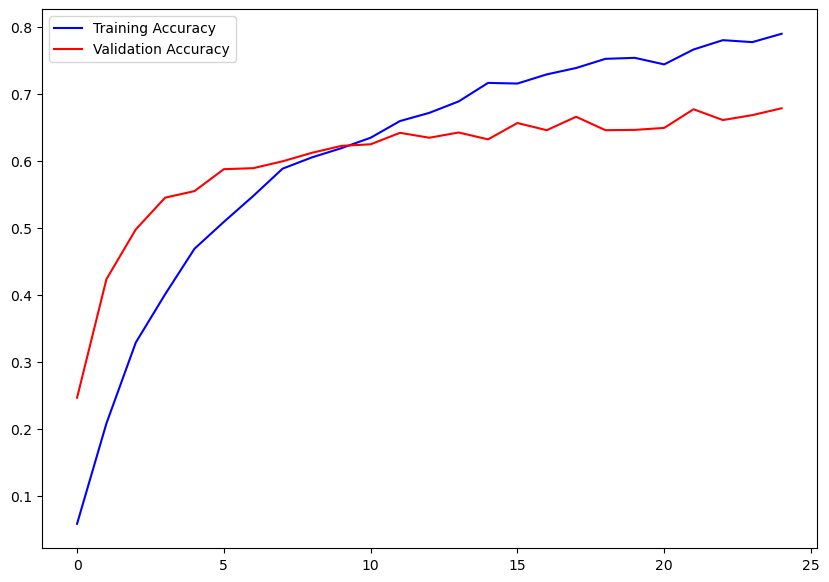

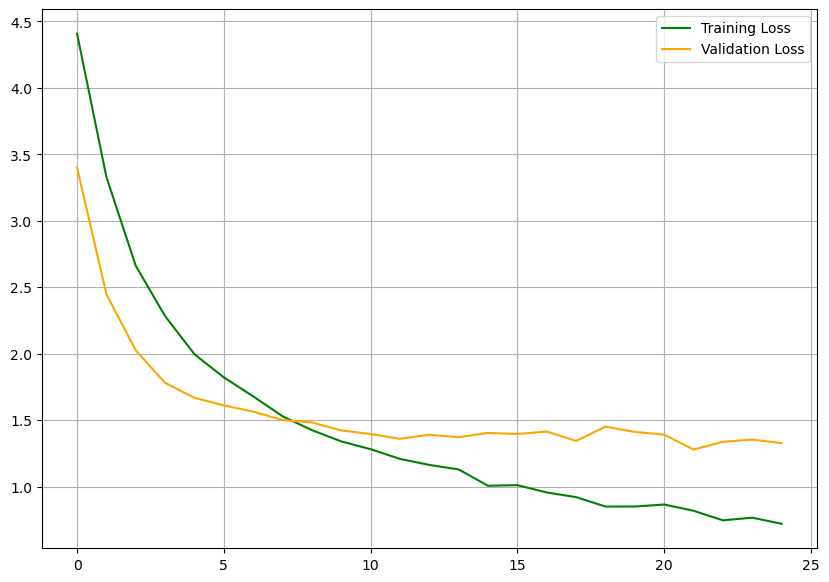

In [12]:
from matplotlib import pyplot as plt
plot_learning_curves(history1)

In [13]:
model.save("/kaggle/working/model_after_fine_tunning.model")

In [31]:
model = tf.keras.models.load_model("/kaggle/working/model_after_fine_tunning.model")

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)              

In [33]:
vgg_part = model.layers[2]

In [34]:
# unfreeze top layers
vgg_part.trainable = True 
for layer in vgg_part.layers[:-8]: 
    layer.trainable = False

# compile and retrain with a low learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['acc']
)

epochs = 15
history2 = model.fit(train_ds, epochs=epochs,
                    validation_data=val_ds)

Epoch 1/15
128/128 [==============================] - 29s 153ms/step - loss: 1.7509 - acc: 0.5550 - val_loss: 1.7395 - val_acc: 0.5628
Epoch 2/15
128/128 [==============================] - 35s 229ms/step - loss: 1.2592 - acc: 0.6573 - val_loss: 1.3901 - val_acc: 0.6346
Epoch 3/15
128/128 [==============================] - 25s 151ms/step - loss: 1.0319 - acc: 0.7176 - val_loss: 1.1639 - val_acc: 0.6834
Epoch 4/15
128/128 [==============================] - 26s 155ms/step - loss: 0.8944 - acc: 0.7555 - val_loss: 1.2148 - val_acc: 0.6893
Epoch 5/15
128/128 [==============================] - 26s 155ms/step - loss: 0.7548 - acc: 0.7833 - val_loss: 1.0941 - val_acc: 0.7147
Epoch 6/15
128/128 [==============================] - 25s 148ms/step - loss: 0.7723 - acc: 0.7782 - val_loss: 1.0655 - val_acc: 0.7264
Epoch 7/15
128/128 [==============================] - 26s 156ms/step - loss: 0.6910 - acc: 0.8048 - val_loss: 1.1346 - val_acc: 0.7323
Epoch 8/15
128/128 [==============================] - 2

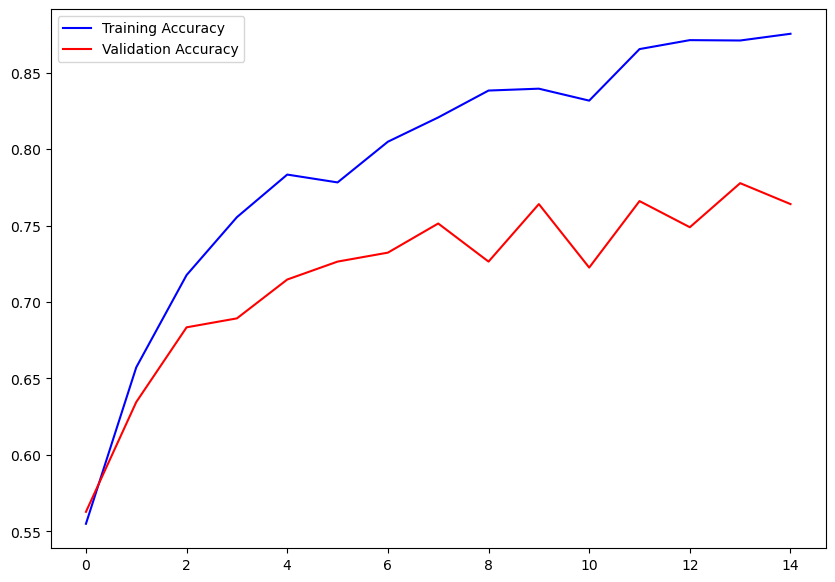

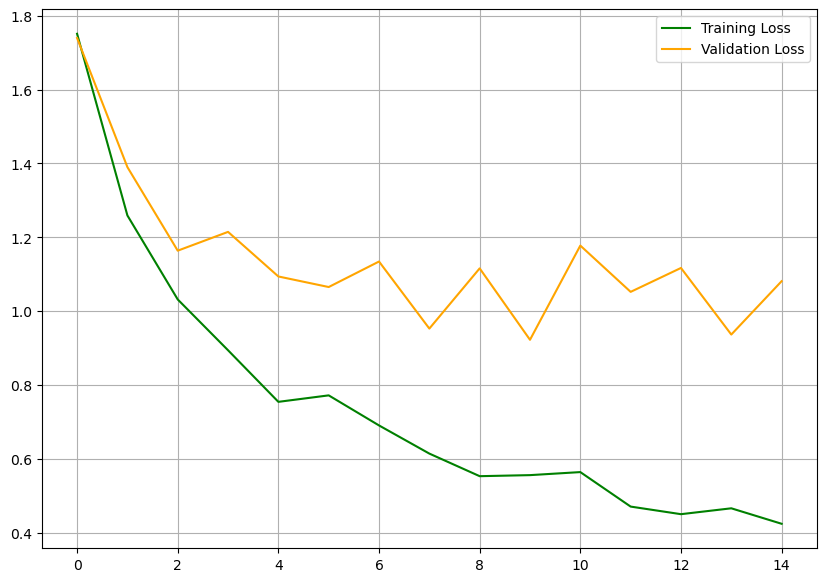

In [35]:
plot_learning_curves(history2)

Epoch 1/15
128/128 [==============================] - 39s 222ms/step - loss: 1.3418 - acc: 0.6436 - val_loss: 1.4832 - val_acc: 0.6307
Epoch 2/15
128/128 [==============================] - 35s 220ms/step - loss: 1.0163 - acc: 0.7228 - val_loss: 1.3402 - val_acc: 0.6448
Epoch 3/15
128/128 [==============================] - 26s 156ms/step - loss: 0.8107 - acc: 0.7680 - val_loss: 1.2030 - val_acc: 0.7049
Epoch 4/15
128/128 [==============================] - 24s 140ms/step - loss: 0.7682 - acc: 0.7750 - val_loss: 1.2556 - val_acc: 0.6957
Epoch 5/15
128/128 [==============================] - 25s 145ms/step - loss: 0.7357 - acc: 0.7846 - val_loss: 1.1844 - val_acc: 0.6991
Epoch 6/15
128/128 [==============================] - 25s 148ms/step - loss: 0.6906 - acc: 0.8051 - val_loss: 1.1823 - val_acc: 0.7054
Epoch 7/15
128/128 [==============================] - 35s 220ms/step - loss: 0.6058 - acc: 0.8300 - val_loss: 1.2628 - val_acc: 0.7054
Epoch 8/15
128/128 [==============================] - 2

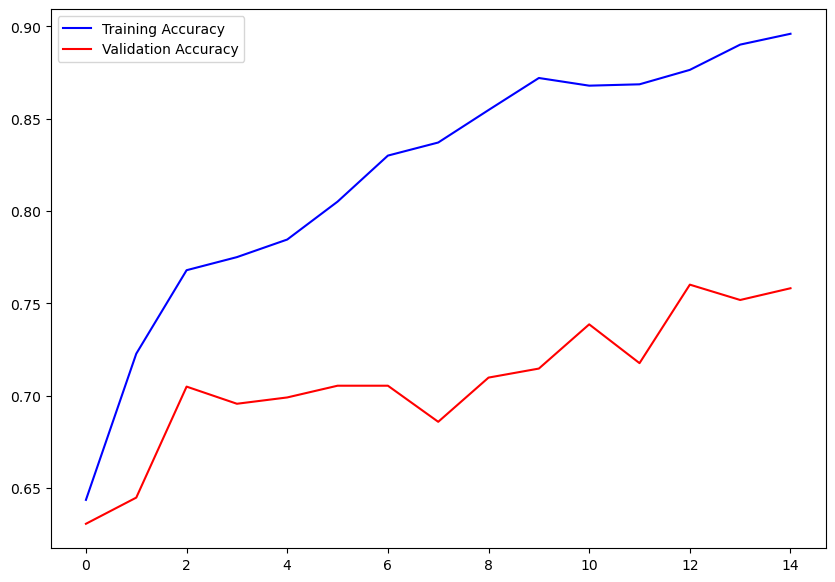

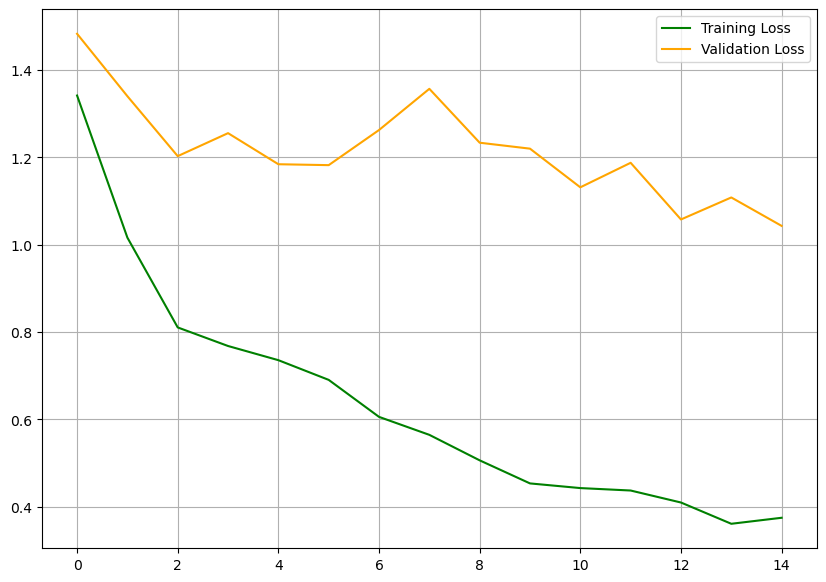

In [36]:
# unfreeze 5 layers
model = tf.keras.models.load_model("/kaggle/working/model_after_fine_tunning.model")
vgg_part = model.layers[2]
# unfreeze top layers
vgg_part.trainable = True 
for layer in vgg_part.layers[:-5]: 
    layer.trainable = False

# compile and retrain with a low learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['acc']
)

epochs = 15
history2 = model.fit(train_ds, epochs=epochs,
                    validation_data=val_ds)
plot_learning_curves(history2)

Epoch 1/15
128/128 [==============================] - 31s 163ms/step - loss: 2.2661 - acc: 0.4375 - val_loss: 1.8948 - val_acc: 0.4978
Epoch 2/15
128/128 [==============================] - 27s 166ms/step - loss: 1.4368 - acc: 0.6126 - val_loss: 1.3588 - val_acc: 0.6341
Epoch 3/15
128/128 [==============================] - 27s 169ms/step - loss: 1.1673 - acc: 0.6761 - val_loss: 1.1559 - val_acc: 0.7069
Epoch 4/15
128/128 [==============================] - 27s 161ms/step - loss: 1.0126 - acc: 0.7174 - val_loss: 1.0580 - val_acc: 0.7215
Epoch 5/15
128/128 [==============================] - 27s 168ms/step - loss: 0.9045 - acc: 0.7511 - val_loss: 0.9890 - val_acc: 0.7474
Epoch 6/15
128/128 [==============================] - 27s 166ms/step - loss: 0.8540 - acc: 0.7658 - val_loss: 1.2185 - val_acc: 0.6883
Epoch 7/15
128/128 [==============================] - 26s 159ms/step - loss: 0.7194 - acc: 0.7997 - val_loss: 0.8718 - val_acc: 0.7645
Epoch 8/15
128/128 [==============================] - 2

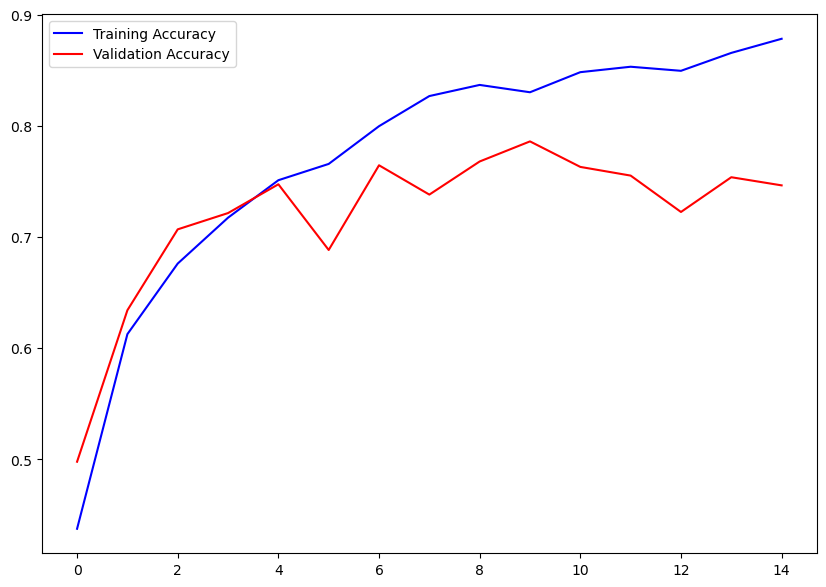

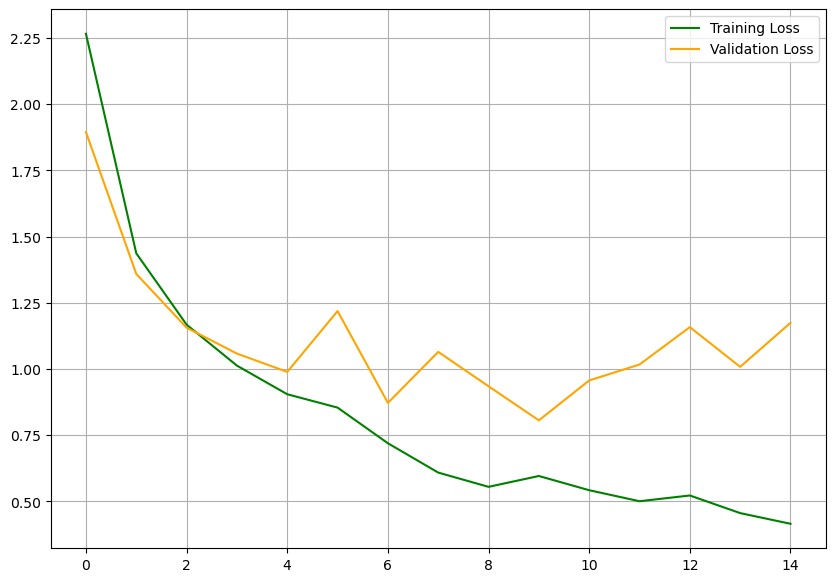

In [37]:
# unfreeze 10 layers
model = tf.keras.models.load_model("/kaggle/working/model_after_fine_tunning.model")
vgg_part = model.layers[2]
# unfreeze top layers
vgg_part.trainable = True 
for layer in vgg_part.layers[:-10]: 
    layer.trainable = False

# compile and retrain with a low learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['acc']
)

epochs = 15
history2 = model.fit(train_ds, epochs=epochs,
                    validation_data=val_ds)
plot_learning_curves(history2)

Epoch 1/15
128/128 [==============================] - 35s 183ms/step - loss: 3.2061 - acc: 0.2726 - val_loss: 1.6101 - val_acc: 0.5701
Epoch 2/15
128/128 [==============================] - 30s 184ms/step - loss: 1.7632 - acc: 0.5266 - val_loss: 1.2274 - val_acc: 0.6615
Epoch 3/15
128/128 [==============================] - 29s 181ms/step - loss: 1.2895 - acc: 0.6473 - val_loss: 1.1449 - val_acc: 0.6834
Epoch 4/15
128/128 [==============================] - 29s 186ms/step - loss: 1.1059 - acc: 0.6954 - val_loss: 1.1029 - val_acc: 0.7054
Epoch 5/15
128/128 [==============================] - 29s 181ms/step - loss: 1.0507 - acc: 0.7032 - val_loss: 1.0759 - val_acc: 0.7128
Epoch 6/15
128/128 [==============================] - 30s 181ms/step - loss: 0.7908 - acc: 0.7704 - val_loss: 0.8753 - val_acc: 0.7596
Epoch 7/15
128/128 [==============================] - 30s 187ms/step - loss: 0.7710 - acc: 0.7829 - val_loss: 0.8732 - val_acc: 0.7665
Epoch 8/15
128/128 [==============================] - 3

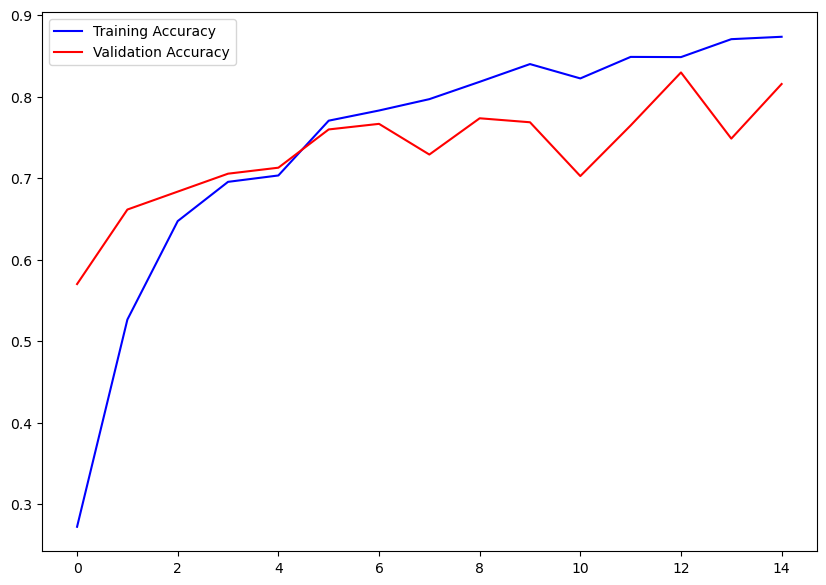

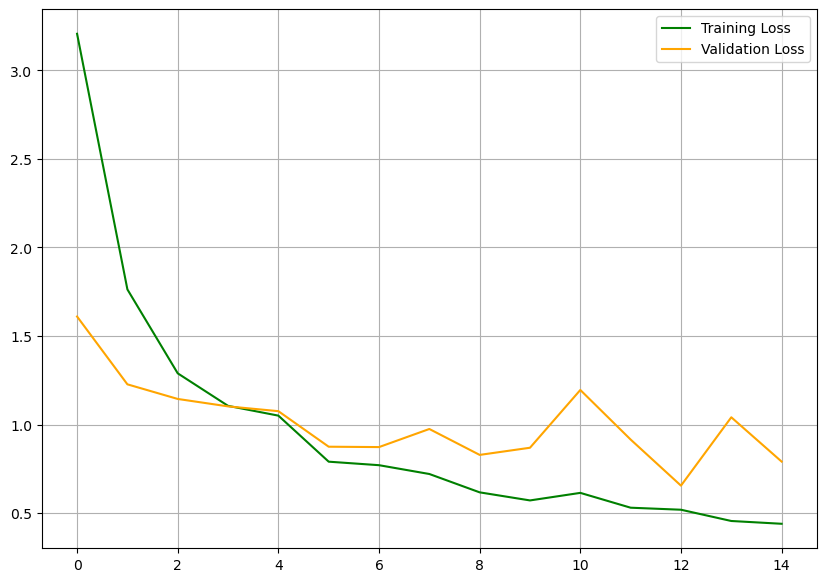

1/1 [==============================] - 0s 23ms/step
accuracy: 0.8076171875


In [105]:
# unfreeze 15 layers
model = tf.keras.models.load_model("/kaggle/working/model_after_fine_tunning.model")
vgg_part = model.layers[2]
# unfreeze top layers
vgg_part.trainable = True 
for layer in vgg_part.layers[:-15]: 
    layer.trainable = False

# compile and retrain with a low learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['acc']
)

epochs = 15
history2 = model.fit(train_ds, epochs=epochs,
                    validation_data=val_ds)
plot_learning_curves(history2)

preds = []
labels = []
for x,y in test_ds:
    preds += list(model.predict(x))
    labels += list(y.numpy())

print("accuracy:", accuracy_score(labels, np.argmax(np.array(preds), axis=1)))

In [39]:
# unfreeze more every 5 epochs
model = tf.keras.models.load_model("/kaggle/working/model_after_fine_tunning.model")
vgg_part = model.layers[2]

histories = []
for num_layers in [5,10,15,20]:
# unfreeze top layers
    vgg_part.trainable = True 
    for layer in vgg_part.layers[:-num_layers]: 
        layer.trainable = False

    # compile and retrain with a low learning rate
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  metrics=['acc']
    )

    epochs = 5
    histories.append(model.fit(train_ds, epochs=epochs,
                        validation_data=val_ds))

Epoch 1/5
128/128 [==============================] - 27s 142ms/step - loss: 1.2768 - acc: 0.6558 - val_loss: 1.4369 - val_acc: 0.6536
Epoch 2/5
128/128 [==============================] - 24s 144ms/step - loss: 1.0109 - acc: 0.7184 - val_loss: 1.2574 - val_acc: 0.6830
Epoch 3/5
128/128 [==============================] - 23s 139ms/step - loss: 0.8595 - acc: 0.7589 - val_loss: 1.2293 - val_acc: 0.7084
Epoch 4/5
128/128 [==============================] - 24s 138ms/step - loss: 0.7993 - acc: 0.7721 - val_loss: 1.3532 - val_acc: 0.6624
Epoch 5/5
128/128 [==============================] - 24s 139ms/step - loss: 0.6648 - acc: 0.8127 - val_loss: 1.1445 - val_acc: 0.7137
Epoch 1/5
128/128 [==============================] - 31s 162ms/step - loss: 1.7580 - acc: 0.5789 - val_loss: 1.3888 - val_acc: 0.6380
Epoch 2/5
128/128 [==============================] - 27s 165ms/step - loss: 1.0112 - acc: 0.7316 - val_loss: 1.3630 - val_acc: 0.6532
Epoch 3/5
128/128 [==============================] - 27s 166ms

In [69]:
preds = model.predict(val_ds)

64/64 [==============================] - 10s 42ms/step


In [83]:
preds = []
labels = []
for x,y in test_ds:
    preds += list(model.predict(x))
    labels += list(y.numpy())

1/1 [==============================] - 0s 24ms/step


In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, np.argmax(np.array(preds), axis=1))

0.7841796875

In [90]:
model = tf.keras.models.load_model("/kaggle/working/model_after_fine_tunning.model")
vgg_part = model.layers[2]
vgg_part.trainable = True 
    

# compile and retrain with a low learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['acc']
)

epochs = 10
history2 = model.fit(train_ds, epochs=epochs,
                    validation_data=val_ds)

Epoch 1/10
128/128 [==============================] - 40s 218ms/step - loss: 2.6934 - acc: 0.3449 - val_loss: 1.9361 - val_acc: 0.4919
Epoch 2/10
128/128 [==============================] - 34s 215ms/step - loss: 1.5573 - acc: 0.5852 - val_loss: 1.3613 - val_acc: 0.6365
Epoch 3/10
128/128 [==============================] - 34s 221ms/step - loss: 1.2845 - acc: 0.6473 - val_loss: 1.1717 - val_acc: 0.6859
Epoch 4/10
128/128 [==============================] - 34s 222ms/step - loss: 1.0704 - acc: 0.7018 - val_loss: 1.0142 - val_acc: 0.7255
Epoch 5/10
128/128 [==============================] - 35s 225ms/step - loss: 0.9922 - acc: 0.7298 - val_loss: 0.9835 - val_acc: 0.7323
Epoch 6/10
128/128 [==============================] - 34s 217ms/step - loss: 0.7874 - acc: 0.7760 - val_loss: 1.0111 - val_acc: 0.7347
Epoch 7/10
128/128 [==============================] - 34s 218ms/step - loss: 0.7853 - acc: 0.7780 - val_loss: 0.8586 - val_acc: 0.7665
Epoch 8/10
128/128 [==============================] - 3

In [91]:
res, info = tfds.load(
    'oxford_flowers102',
    split='test+train+validation',
    shuffle_files = True,
    as_supervised=True,
    with_info=True
)


In [92]:
train_size = int(len(res) * 0.5)
val_size = int(len(res) * 0.25)
test_size = len(res) - train_size - val_size
train_ds2 = res.take(train_size)
val_ds2 = res.skip(train_size).take(val_size)
test_ds2 = res.skip(train_size).skip(val_size)
assert(len(test_ds2) == test_size)
train_ds2 = create_dataset(train_ds2)
val_ds2 = create_dataset(val_ds2)
test_ds2 = create_dataset(test_ds2)

Epoch 1/25
128/128 [==============================] - 25s 131ms/step - loss: 4.4080 - acc: 0.0630 - val_loss: 3.3479 - val_acc: 0.2609
Epoch 2/25
128/128 [==============================] - 22s 130ms/step - loss: 3.3205 - acc: 0.2157 - val_loss: 2.4001 - val_acc: 0.4216
Epoch 3/25
128/128 [==============================] - 22s 130ms/step - loss: 2.6576 - acc: 0.3307 - val_loss: 2.0610 - val_acc: 0.4665
Epoch 4/25
128/128 [==============================] - 22s 129ms/step - loss: 2.3006 - acc: 0.4050 - val_loss: 1.8715 - val_acc: 0.5203
Epoch 5/25
128/128 [==============================] - 22s 131ms/step - loss: 2.0075 - acc: 0.4700 - val_loss: 1.5972 - val_acc: 0.5677
Epoch 6/25
128/128 [==============================] - 23s 133ms/step - loss: 1.7761 - acc: 0.5281 - val_loss: 1.4994 - val_acc: 0.6063
Epoch 7/25
128/128 [==============================] - 23s 129ms/step - loss: 1.6384 - acc: 0.5584 - val_loss: 1.5491 - val_acc: 0.5945
Epoch 8/25
128/128 [==============================] - 2

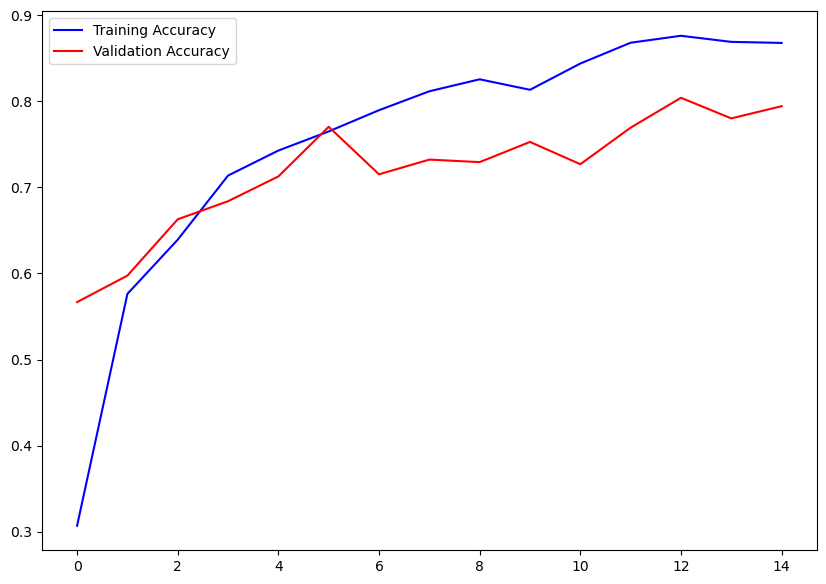

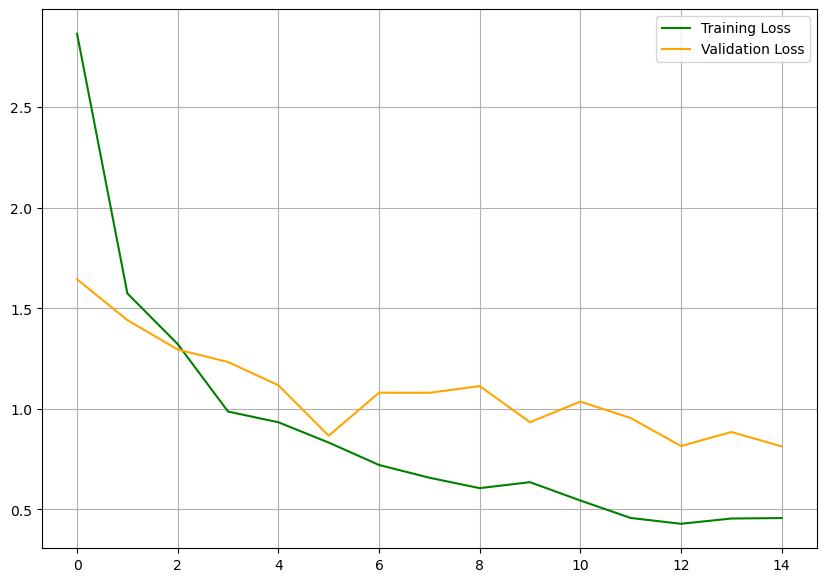

1/1 [==============================] - 0s 22ms/step
accuracy: 0.79150390625


In [104]:
base_model = tf.keras.applications.VGG19(
        input_shape=(150, 150, 3),
        include_top=False,
        weights="imagenet",
)
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    data_augmentation,
    layers.Rescaling(scale=1.0/255),
    base_model,
    # new layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(102, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['acc']
             )

epochs = 25
history1 = model.fit(train_ds2, epochs=epochs,
                   validation_data=val_ds2)

# unfreeze 15 layers
vgg_part = model.layers[2]
# unfreeze top layers
vgg_part.trainable = True 
for layer in vgg_part.layers[:-15]: 
    layer.trainable = False

# compile and retrain with a low learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['acc']
)

epochs = 15
history2 = model.fit(train_ds2, epochs=epochs,
                    validation_data=val_ds2)
plot_learning_curves(history2)

preds = []
labels = []
for x,y in test_ds2:
    preds += list(model.predict(x))
    labels += list(y.numpy())

print("accuracy:", accuracy_score(labels, np.argmax(np.array(preds), axis=1)))

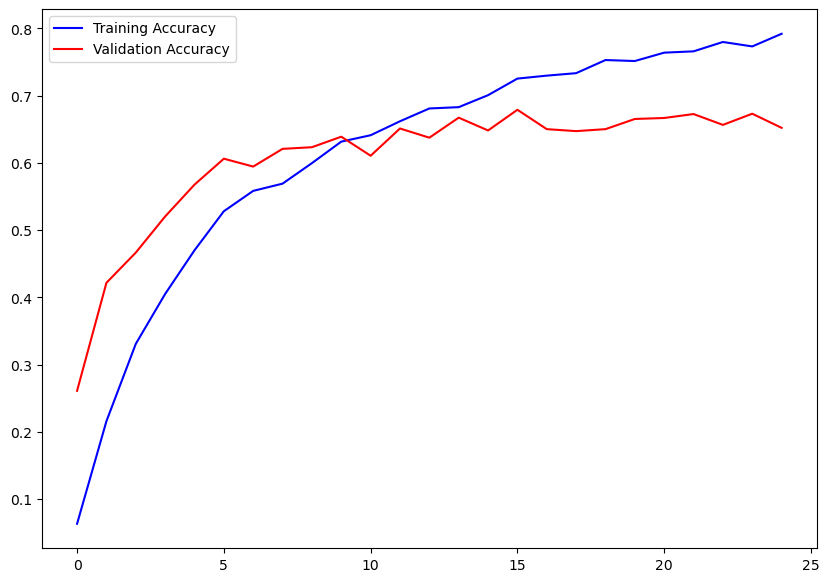

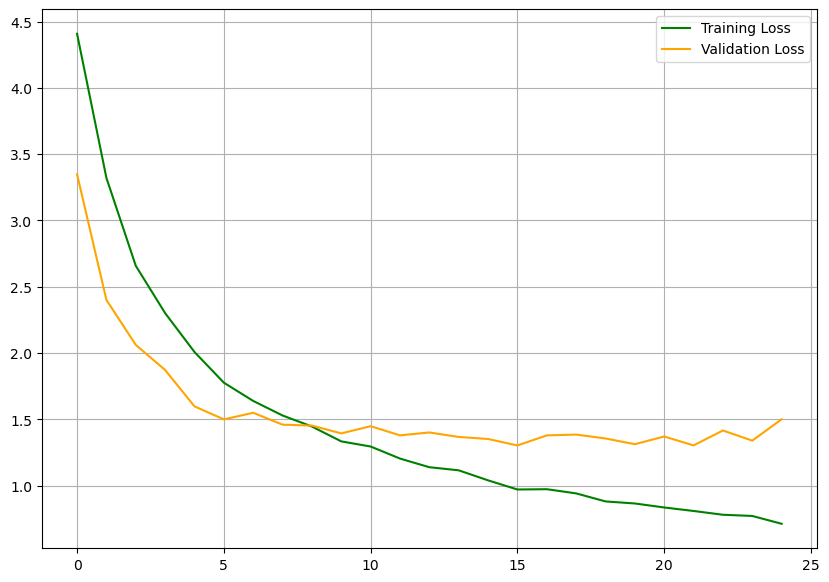

In [107]:
epochs = 25
plot_learning_curves(history1)